In [103]:
# pip install -U pymoo

In [104]:
import numpy as np
import pandas as pd
import json
from util import *

from data_preprocess import *
from run_ga import *
import matplotlib.pyplot as plt
import pickle

In [105]:
tet_path = "./data/tet.json"
fdr_path = "./data/all_class_mutation/Chart-1_fdr.json"

with open(tet_path, 'r') as f:
    tet_data = json.load(f)


with open(fdr_path, 'r') as f:
    fdr_data = json.load(f)

chart_1_tet = tet_data['Chart-1']
chart_1_fdr = dict()

for key, value in fdr_data['Chart_1'].items():
    chart_1_fdr[key] = value['mutation-score']


chart_1_tet = sorted(chart_1_tet.items())
chart_1_fdr = sorted(chart_1_fdr.items())

In [106]:
tests = [i[0] for i in chart_1_tet]
execution_times = np.array([i[1] for i in chart_1_tet])
fault_detections = np.array([i[1] for i in chart_1_fdr])

test_cases = np.column_stack((execution_times, fault_detections))
adequacy_scores = get_adequacy_scores(fault_detections)

Scaling Method: min_max


In [107]:
bitflip = run_nsga(test_cases, False)


Using 1/N Mutation 
Mean execution Time 5.209684210526316
Mean Fault Detection Rate 2.062597777063425


In [108]:
adeq = run_nsga_with_adequecy(test_cases, adequacy_scores, False)


 Using Adequacy Score
Mean execution Time 5.509285714285714
Mean Fault Detection Rate 2.1484228338753604


In [109]:
# bitflip_res = np.abs(bitflip.F)
# adeq_res = np.abs(adeq.F)

# plt.scatter(bitflip_res[:, 0], bitflip_res[:, 1], label="Bitflip")
# plt.scatter(adeq_res[:, 0], adeq_res[:, 1], label="Adequacy")
# plt.xlabel("TET")
# plt.ylabel("FDR")
# plt.legend()

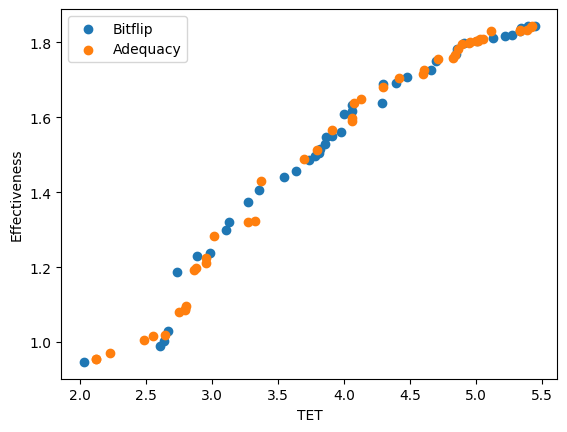

In [110]:
with open('data/experiment_result/f_fdr_m_fdr/Chart_1_bitflip.pkl', 'rb') as f:
    bitflip = pickle.load(f)

with open('data/experiment_result/f_fdr_m_fdr/Chart_1_adeq.pkl', 'rb') as f:
    adeq = pickle.load(f)
# print(data.F)

bitflip_res = bitflip_res = np.abs(bitflip.F)
adeq_res = np.abs(adeq.F)

plt.scatter(bitflip_res[:, 0], bitflip_res[:, 1], label="Bitflip")
plt.scatter(adeq_res[:, 0], adeq_res[:, 1], label="Adequacy")
plt.xlabel("TET")
plt.ylabel("Effectiveness")
plt.legend()

f_cov_m_cov
3 8
JacksonCore 3 8
adequacy 1.8450000000000002 bitflip 1.923
2 4
Chart 2 4
adequacy 2.247 bitflip 2.311
0 0
Lang 0 0
adequacy 0.089 bitflip 0.093
5 0
Csv 5 0
adequacy 0.506 bitflip 0.35300000000000004
1 0
Time 1 0
adequacy 1.6020000000000003 bitflip 1.613
8 1
Cli 8 1
adequacy 0.0 bitflip 0.0
1 24
JxPath 1 24
adequacy 0.9 bitflip 2.099
f_cov_m_cov
{'JacksonCore_26': {'adeq': 1.8450000000000002, 'bigflip': 1.923}, 'Chart_1': {'adeq': 2.247, 'bigflip': 2.311}, 'Lang_1': {'adeq': 0.089, 'bigflip': 0.093}, 'Csv_16': {'adeq': 0.506, 'bigflip': 0.35300000000000004}, 'Time_1': {'adeq': 1.6020000000000003, 'bigflip': 1.613}, 'Cli_40': {'adeq': 0.0, 'bigflip': 0.0}, 'JxPath_22': {'adeq': 0.9, 'bigflip': 2.099}}
{'adeq': 1.8450000000000002, 'bigflip': 1.923}
{'adeq': 2.247, 'bigflip': 2.311}
{'adeq': 0.089, 'bigflip': 0.093}
{'adeq': 0.506, 'bigflip': 0.35300000000000004}
{'adeq': 1.6020000000000003, 'bigflip': 1.613}
{'adeq': 0.0, 'bigflip': 0.0}
{'adeq': 0.9, 'bigflip': 2.099}
['Ja

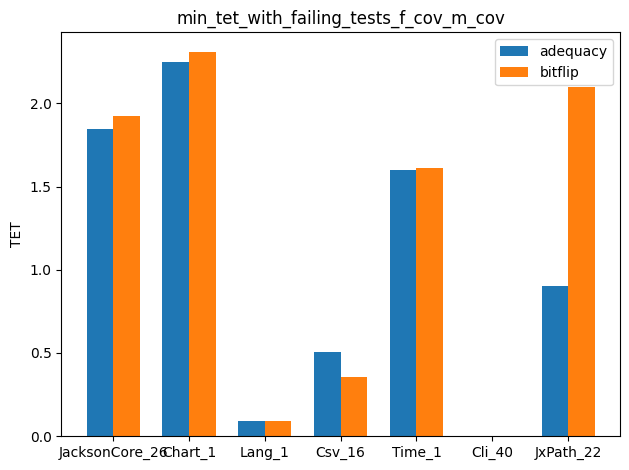

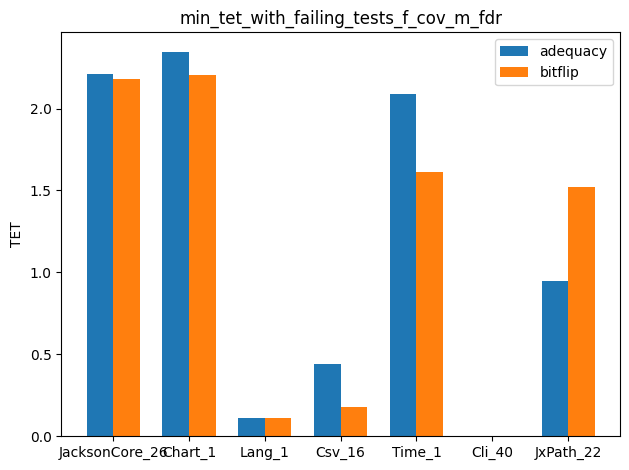

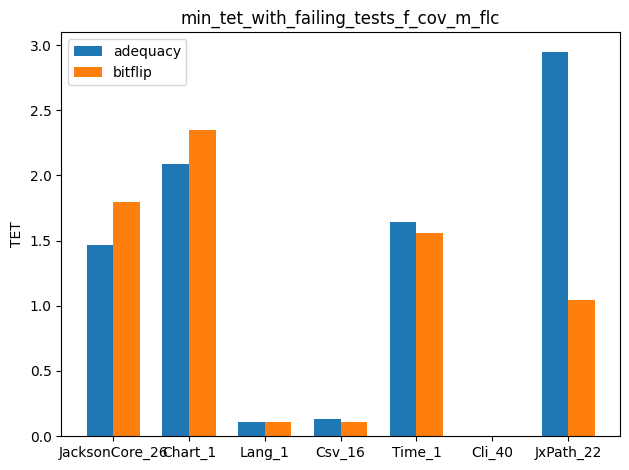

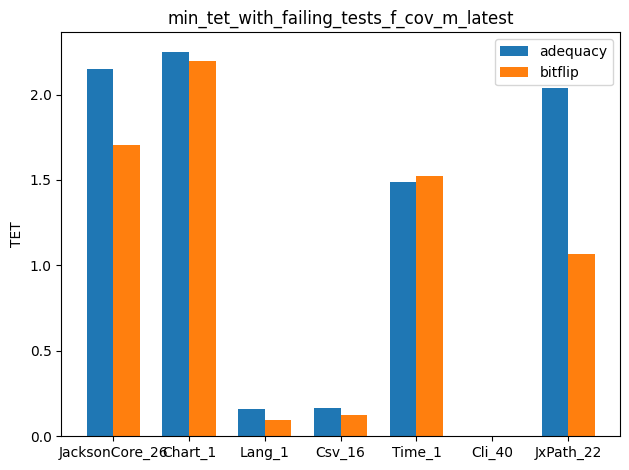

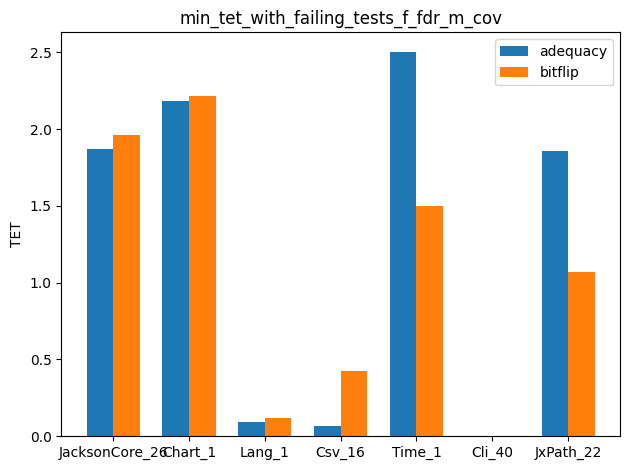

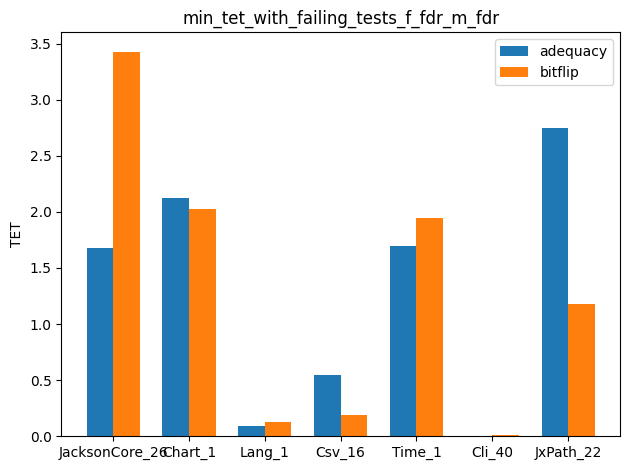

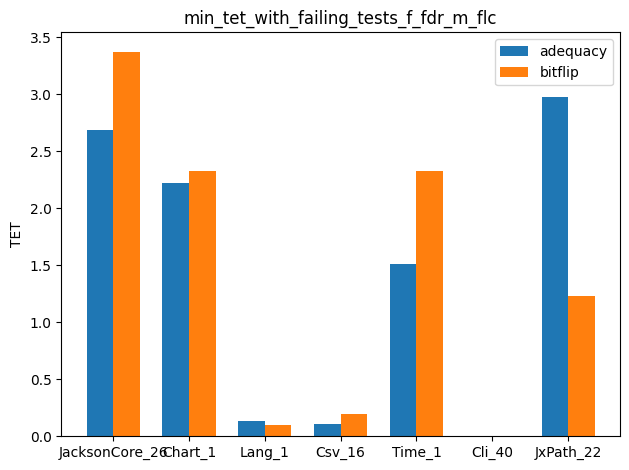

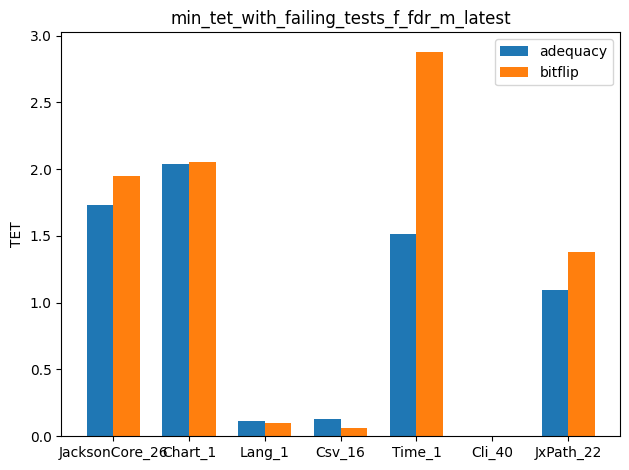

In [111]:
types = [
    'f_cov_m_cov',
    'f_cov_m_fdr',
    'f_cov_m_flc',
    'f_cov_m_latest',
    'f_fdr_m_cov',
    'f_fdr_m_fdr',
    'f_fdr_m_flc',
    'f_fdr_m_latest'
]

tet_dict = {}
for type in types:
    print(type)
    for target in os.listdir('./data/merged_data'):
        pid, vid = os.path.splitext(target)[0].split('_')

        with open(f'data/experiment_result/{type}/{pid}_{vid}_bitflip.pkl', 'rb') as f:
            bitflip = pickle.load(f)

        with open(f'data/experiment_result/{type}/{pid}_{vid}_adeq.pkl', 'rb') as f:
            adeq = pickle.load(f)

        with open(f'data/merged_data/{pid}_{vid}.pkl', 'rb') as f:
            data = pickle.load(f)

        with open(f"data/failing_tests/{pid}-{vid}/failing_tests", "r") as f:
            failing_tests = f.readlines()

        min_id_adeq = None
        for i, sol in enumerate(adeq.X):
            
            # print(data.index[sol].shape)
            selected_tests = data.index[sol]
            if all(test in selected_tests for test in failing_tests):
                tet = adeq.F[i, 0]
                if min_id_adeq == None:
                    min_id_adeq = i
                elif tet < adeq.F[min_id_adeq, 0]:
                    min_id_adeq = i

        min_id_bitflip = None
        for i, sol in enumerate(bitflip.X):
            selected_tests = data.index[sol]
            if all(test in selected_tests for test in failing_tests):
                tet = bitflip.F[i, 0]
                if min_id_bitflip == None:
                    min_id_bitflip = i
                elif tet < bitflip.F[min_id_bitflip, 0]:
                    min_id_bitflip = i
                    
        adeq_tet = np.inf if min_id_adeq == None else adeq.F[min_id_adeq, 0]
        bitflip_tet = np.inf if min_id_bitflip ==  None else bitflip.F[min_id_bitflip, 0]

        # print("Adeq tet")
        # print(adeq.F[min_id_adeq, 0])
        # print("Bitflip tet")
        # print(bitflip.F[min_id_bitflip, 0])
        # print("\n")
  
        tet_dict[f"{pid}_{vid}"] = {"adeq": adeq_tet, "bigflip": bitflip_tet}

    plot_figure_tet(tet_dict, type)
    with open(f"./data/experiment_result/{type}/min_tet_with_failing_tests.json", 'w') as f:
        json.dump(tet_dict, f)
